# **Import Library**

In [ ]:
import io
import sys
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **Read JSON File**

In [ ]:
with open('recipe.json', 'r') as f:
    data = json.load(f)

# **Define Path**

In [ ]:
word_index_path = 'word_index.json'
tags_path = 'tag.json'
model_path = 'model.h5'

# **Setting Parameters**

In [ ]:
MAX_INGREDIENTS = 2
MAX_WORDS_IN_INGREDIENT = 10
MAX_TAGS = 200
MAX_VOCAB_SIZE = 10000

# **Load + Save Tags and Word Index**

In [ ]:
def load_tags():
    try:
        f = open(tags_path, 'r')
        tags = json.loads(f.read())
        f.close()
    except FileNotFoundError:
        tags = []
    return tags
def save_tags(tags):
    tags_file = open(tags_path, 'w+')
    tags_file.write(json.dumps(tags))
    tags_file.close()

In [ ]:
def load_word_index():
    try:
        f = open(word_index_path, 'r')
        word_index = json.loads(f.read())
        f.close()
    except FileNotFoundError:
        word_index = {'<PAD>': 0, '<OOV>': 1}
    return word_index

def save_word_index(word_index):
    word_index_file = open(word_index_path, 'w+')
    word_index_file.write(json.dumps(word_index))
    word_index_file.close()

# **Preprocessing**

## **Tokenizing, Sequencing, and Padding Ingredients**

In [ ]:
def preprocess(dataframe):
    tokenizer = keras.preprocessing.text.Tokenizer(lower=True, filters=' ')

    # Tokenizing word_index and creating vocabulary of word_index
    word_index = load_word_index()
    for recipe in data:
        for ingredient in recipe['ingredients']:
            tokenizer.fit_on_texts([ingredient])

    word_index.update(tokenizer.word_index)
    save_word_index(word_index)

    # Creating list of recipe tags
    tags = load_tags()
    for recipe in data:
        tag_lower = recipe['tag'].lower()
        if tag_lower not in tags:
            tags.append(tag_lower)
    save_tags(tags)

    # Tokenizing and padding the ingredients
    train_data = []
    for recipe in data:
        recipe_data = tokenizer.texts_to_sequences(recipe['ingredients'])
        recipe_data = [item for sublist in recipe_data for item in sublist]  # Flatten the nested list
        train_data.append(recipe_data)

    # Padding the number of ingredients and words in each recipe
    train_data = keras.preprocessing.sequence.pad_sequences(train_data, padding='post', maxlen=MAX_INGREDIENTS * MAX_WORDS_IN_INGREDIENT, value=0)
    train_labels = [tags.index(dish['tag'].lower()) for dish in data]
    train_labels = keras.utils.to_categorical(train_labels, num_classes=MAX_TAGS)

    return train_data, train_labels, word_index, tags

In [ ]:
train_data, train_labels, word_index, tags = preprocess(data)

In [ ]:
train_data.shape

(200, 20)

In [ ]:
train_labels.shape

(200, 200)

# **Creating The Model**

In [ ]:
def create_model(max_vocab_size, max_tags):

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_vocab_size, 64),
        tf.keras.layers.Dropout(.1),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(.1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(.1),
        tf.keras.layers.Dense(max_tags, activation='softmax')
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model(MAX_VOCAB_SIZE, MAX_TAGS)
history = model.fit(train_data, train_labels, epochs=300, verbose=2)

Epoch 1/300
7/7 - 1s - loss: 5.3021 - accuracy: 0.0050 - 1s/epoch - 185ms/step
Epoch 2/300
7/7 - 0s - loss: 5.2959 - accuracy: 0.0150 - 108ms/epoch - 15ms/step
Epoch 3/300
7/7 - 0s - loss: 5.2947 - accuracy: 0.0050 - 106ms/epoch - 15ms/step
Epoch 4/300
7/7 - 0s - loss: 5.2906 - accuracy: 0.0100 - 104ms/epoch - 15ms/step
Epoch 5/300
7/7 - 0s - loss: 5.2872 - accuracy: 0.0050 - 108ms/epoch - 15ms/step
Epoch 6/300
7/7 - 0s - loss: 5.2876 - accuracy: 0.0100 - 89ms/epoch - 13ms/step
Epoch 7/300
7/7 - 0s - loss: 5.2830 - accuracy: 0.0200 - 95ms/epoch - 14ms/step
Epoch 8/300
7/7 - 0s - loss: 5.2796 - accuracy: 0.0250 - 119ms/epoch - 17ms/step
Epoch 9/300
7/7 - 0s - loss: 5.2748 - accuracy: 0.0350 - 99ms/epoch - 14ms/step
Epoch 10/300
7/7 - 0s - loss: 5.2698 - accuracy: 0.0250 - 102ms/epoch - 15ms/step
Epoch 11/300
7/7 - 0s - loss: 5.2658 - accuracy: 0.0350 - 116ms/epoch - 17ms/step
Epoch 12/300
7/7 - 0s - loss: 5.2615 - accuracy: 0.0450 - 99ms/epoch - 14ms/step
Epoch 13/300
7/7 - 0s - loss: 5

# **Evaluating The Model**

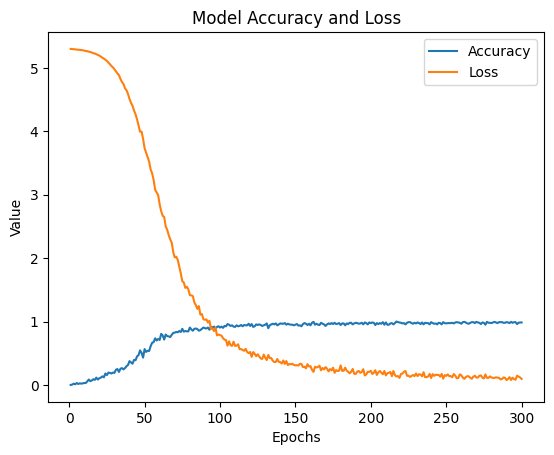

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Model Accuracy and Loss')
plt.legend()
plt.show()

# **Predicting**

In [ ]:
def preprocess_input(user_input):
    tokenizer = keras.preprocessing.text.Tokenizer(lower=True, filters=' ')

    word_index = load_word_index()
    for recipe in data:
        for ingredient in recipe['ingredients']:
            tokenizer.fit_on_texts([ingredient])

    word_index.update(tokenizer.word_index)
    save_word_index(word_index)

    # Tokenizing and padding the user input
    user_data = tokenizer.texts_to_sequences(user_input)
    user_data = [item for sublist in user_data for item in sublist]  # Flatten the nested list

    # Padding the number of ingredients and words in the user data
    user_data = pad_sequences([user_data], padding='post', maxlen=MAX_INGREDIENTS * MAX_WORDS_IN_INGREDIENT, value=0)

    return user_data

In [ ]:
def get_top_labels(model, preprocessed_input, tags, top_k=5):
    predictions = model.predict(preprocessed_input)
    top_indices = np.argsort(predictions[0])[::-1][:top_k]
    top_labels = [tags[index] for index in top_indices]
    return top_labels, top_indices

In [ ]:
def predict_labels(ingredients_list):
    preprocessed_input = preprocess_input(ingredients_list)
    top_labels, top_indices = get_top_labels(model, preprocessed_input, tags, top_k=5)
    return top_labels, top_indices

In [ ]:
top_labels, top_indices = predict_labels(["egg","milk","flour"])
print("Predicted Index: " + ", ".join(str(item) for item in top_indices))
print("Predicted recipe : " + ", ".join(str(item) for item in top_labels))

1/1 [==============================] - 0s 69ms/step
Predicted Index: 47, 49, 83, 145, 189
Predicted recipe : suesricemuffin, lemonloaf, nuttychocolatechunkcookies, peanutbutterpumpkincookies, cornpudding


# **Saving Model**

In [ ]:
keras.models.save_model(model, model_path)
print('trained model saved')

trained model saved
